# **N03. Object detection**

# 1. Load libraries

In [1]:
from utilities import*
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import math
import pandas as pd
from astropy.stats import sigma_clipped_stats
from scipy.spatial import distance

In [2]:
def plot_fits(fits_file):
    """
    Plot .fits file with the timestamp and wave information.
    
    """
    fig, axis = plt.subplots(1,1, figsize=(7,7))
    axis.imshow(fits_file[0].data, cmap = "grey", vmin=fits_file[0].header["DATAMIN"],
                vmax=fits_file[0].header["DATAMAX"])
    axis.set_xlabel("detector x")
    axis.set_ylabel("detector y")
    axis.set_title(f'{fits_file[0].header["LEVEL"]} {fits_file[0].header["FILE_RAW"][:18]}')

# 2. Load image

Load the global parameters for the spice kernel and the image to be analyzed.

In [3]:
# GLOBAL PARAMETERS
KERNEL_PATH = "/home/stefano98/University of Padua/thesis/Packages/Solar-orbiter/kernels/mk"
KERNEL_NAME = "solo_ANC_soc-flown-mk.tm"
DATASET_DIR_L0 = "/home/stefano98/University of Padua/thesis/dataset/L0"
IMG = "solo_L0_metis-vl-image_0757398438_V01.fits"

Plot .fits image.

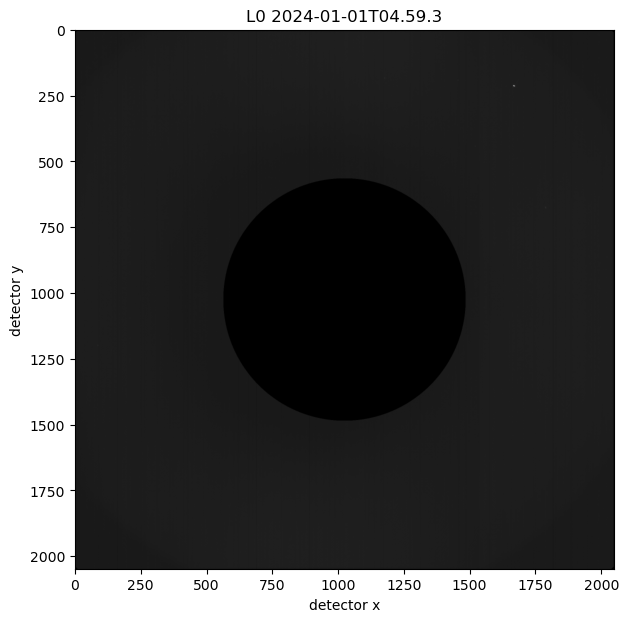

In [4]:
image = fits.open(os.path.join(DATASET_DIR_L0, IMG))
timestamp = extract_timestamp(image)
plot_fits(image)

Plot the detected stars.

In [5]:
image[0].header

SIMPLE  =                    T / file comforms to FITS standard                 
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 2048 / length of data axis 1                          
NAXIS2  =                 2048 / length of data axis 2                          
EXTEND  =                    T / FITS file contains extensions                  
LONGSTRN= 'OGIP 1.0'           / FITS header contains long strings              
FILENAME= 'solo_L0_metis-vl-image_0757398438_V01.fits' / FITS filename          
FILE_RAW= '2024-01-01T04.59.34.737730Z-VL_IMAGE.raw' / filename of raw data     
APID    =                 1084 / APID number of associated telemetry            
OBT_BEG =    757398438.2911987 / start acquisition time in OBT                  
OBT_END =     757400153.509201 / end acquisition time in OBT                    
LEVEL   = 'L0      '        

In [6]:
table = stars_detector(KERNEL_NAME, KERNEL_PATH, timestamp, False)
# Plot PSFs.
raw_data = image[0].data
fig, axis = plt.subplots(1, 5, figsize = (20, 4))
plt.suptitle(f"Detected objects in {image[0].header['FILENAME']}")
fig.supxlabel("Detector x")
fig.supylabel("Detector y")
lim = 10
for i in range(len(table[0])):
    x = int(table[0]["xsensor"][i])
    y = int(table[0]["ysensor"][i])
    star_name = table[0]["MAIN_ID"][i]
    axis[i].imshow(raw_data[y-lim:y+lim, x-lim:x+lim])
    axis[i].set_title(star_name)


ValueError: Coordinates conversion and formatting is no longer supported within the SIMBAD module. This can be done with the `~astropy.coordinates` module.Coordinates are now per default in degrees and in the ICRS frame.

# 3. Object detection

## 3.1 Blob detection

In [13]:
from math import sqrt
from skimage.io import imread, imshow
from skimage.color import rgb2gray, label2rgb
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.morphology import erosion, dilation, opening, closing
from skimage.measure import label, regionprops
from skimage.feature import blob_dog, blob_log, blob_doh

First, let's crop a section in the real image where interesting points may be found. Then, plot it and do histograms.

((array([1964.,   12.,    4.,    4.,    0.,    4.,    4.,    4.,    0.,
            4.]),
  array([ 1677. ,  2997.9,  4318.8,  5639.7,  6960.6,  8281.5,  9602.4,
         10923.3, 12244.2, 13565.1, 14886. ]),
  <BarContainer object of 10 artists>),
 Text(0.5, 1.0, 'Fits L0 histogram'))

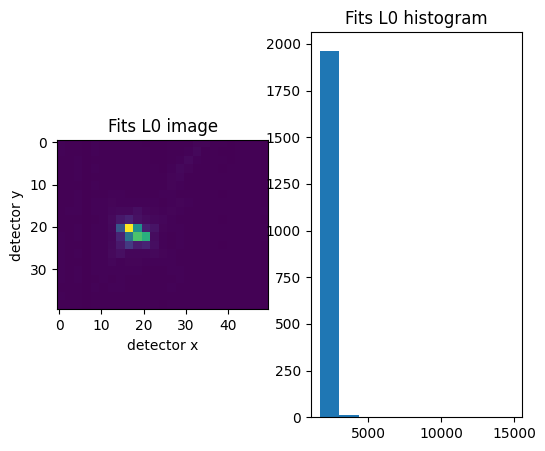

In [14]:
# Define image to work.
raw_data = image[0].data
# Crop region of interest.
croped_img = raw_data[190:230,1650:1700]
# Plot image and histogram.
fig, axis = plt.subplots(1,2, figsize=(6, 5))
axis[0].imshow(croped_img), axis[0].set_xlabel("detector x"), axis[0].set_ylabel("detector y"), axis[0].set_title("Fits L0 image")
axis[1].hist(croped_img.flatten()), axis[1].set_title("Fits L0 histogram")

Fits image must be normalize to 0-1 in order to apply better blob detection. Normalize it and plot again.

((array([1964.,   12.,    4.,    4.,    0.,    4.,    4.,    4.,    0.,
            4.]),
  array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
  <BarContainer object of 10 artists>),
 Text(0.5, 1.0, 'Fits L0 histogram'))

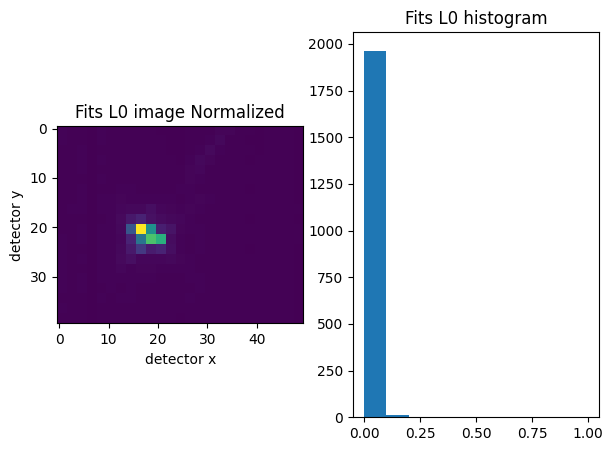

In [15]:
# Normalize array.
def normalize_array(croped_img):
    """
    Normalize array given max and min value of the .fits
    """
    max_val = np.max(croped_img.flatten())
    min_val = np.min(croped_img.flatten())
    return (croped_img - min_val) / (max_val - min_val)

# Normalize and compute histogram.
norm_cropped_img = normalize_array(croped_img)
fig, axis = plt.subplots(1, 2, figsize = (7,5))
axis[0].imshow(norm_cropped_img), axis[0].set_xlabel("detector x"), axis[0].set_ylabel("detector y"), axis[0].set_title("Fits L0 image Normalized")
axis[1].hist(norm_cropped_img.flatten()), axis[1].set_title("Fits L0 histogram")


Apply mask and run blob detection.

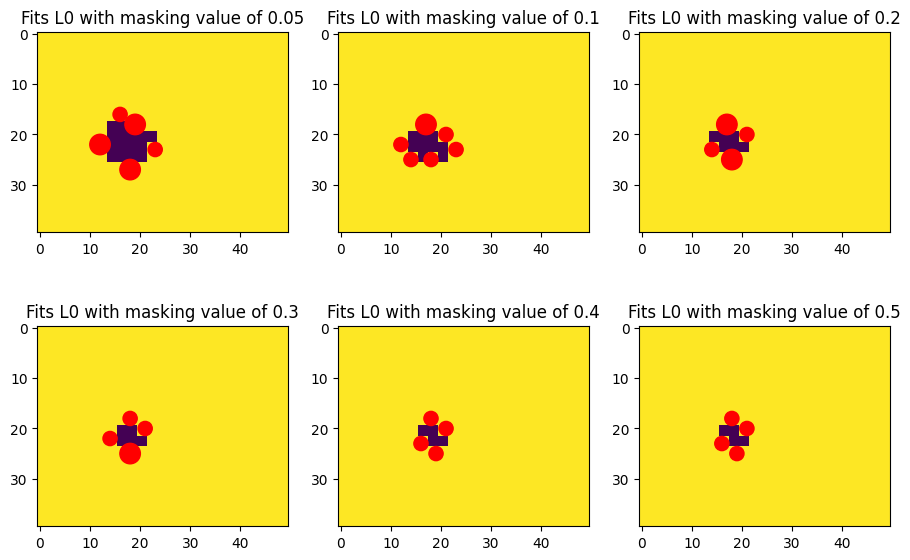

In [16]:
fig, axis = plt.subplots(2,3, figsize = (11, 7))
mask_vals = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
axis = axis.flatten()
for i in range(6):
    axis[i].imshow((norm_cropped_img < mask_vals[i]) *1)
    mask = norm_cropped_img < mask_vals[i]
    blobs = blob_log(mask, max_sigma=5, threshold=0.1)
    for blob in blobs:
        y, x, area = blob
        axis[i].add_patch(plt.Circle((x, y), area*np.sqrt(2), color = "red"))
        
    axis[i].set_title(f"Fits L0 with masking value of {mask_vals[i]}")

Test with full image.

In [17]:
# Normalize full image
full_image_norm = normalize_array(raw_data)
mask = full_image_norm < 0.1
# Compute blobs from 1 to 3 sigma (interval).
blobs = blob_log(mask, min_sigma = 1, max_sigma=3, threshold=0.1)

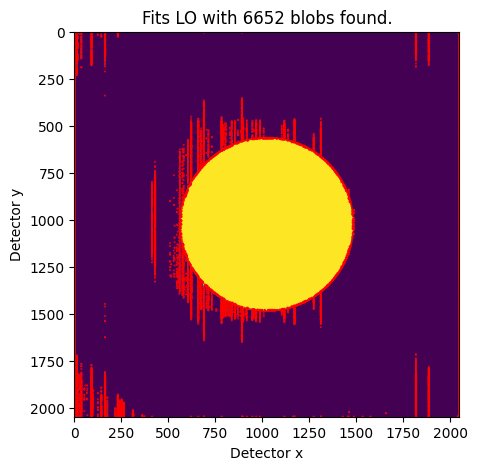

In [18]:
# Plot blobs.
fig, axis = plt.subplots(1,1, figsize = (5,5))
axis.imshow(mask)
axis.set_title(f"Fits LO with {len(blobs)} blobs found.")
axis.set_xlabel("Detector x")
axis.set_ylabel("Detector y")
for blob in blobs:
    y, x, area = blob
    axis.add_patch(plt.Circle((x, y), area*np.sqrt(2), color = "red"))
    

Due to the noise in the image, blob detection is not useful. Also because it is more used for edge detection.

## 3.2 Peak detection

### 3.2.1 Load libraries

First, load the require libraries.

In [11]:
from photutils import centroids
from astropy.table import Table
from photutils.detection import find_peaks
import itertools
from scipy.ndimage import gaussian_filter

Plot test image where peaks will be analyzed.

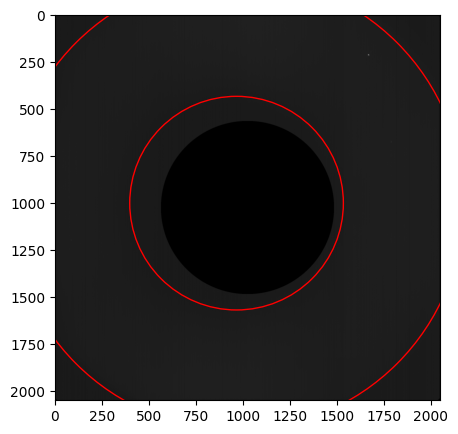

In [12]:
# Define image to work.
raw_data = image[0].data

fig, axis = plt.subplots(1, 1, figsize =(5,5))
axis.imshow(raw_data, cmap = "grey")

axis.add_patch(plt.Circle((table[2]), METIS_fov/table[1], color = "red", fill = None))
axis.add_patch(plt.Circle((table[2]), METIS_fov_min/table[1], color = "red", fill = None))

### 3.2.2 Create proposal regions

Create a function that takes a 2d array and returns a set of cropped regions. These regions may be overlapped and are predefined by a size parameter.

In [13]:
def image_slicer(image, size, overlapping_size = 3):
    """
    Slice a 2D-numpy array into several symmetrical regions that may share borders
    with its neighbors.


    Args:
        image (array): .fits image.
        size (int): size of the proposal region.
        overlapping (int): indicate length of share region (overlapping).

    Return:
        proposal_regions (list): list with proposed regions.
        proposal_coordinates (list): list with the coordinates from the original image.

    """

    # Extract size of image.
    size_x, size_y = image.shape
    # Create grid for storing positions

   
    image_coordinates = np.zeros((size_x,size_y), dtype=object)
    size_x_vals = np.arange(size_x)
    size_y_vals = np.arange(size_y)

    for idx, valx in enumerate(size_x_vals):
        for idy, valy in enumerate(size_y_vals):
            image_coordinates[idx, idy] = [valx, valy]

    # Add padding for obtaining uniform regions.
    n_regionsx = math.ceil(size_x/size)
    n_regionsy = math.ceil(size_y/size)

    padding_x = (n_regionsx*size - size_x)/2
    padding_y = (n_regionsy*size - size_y)/2

    # Add "False" padding to the borders of the image. If padding is even, then it is symmetrical.
    image = np.pad(image, [(math.ceil(padding_x), math.floor(padding_x) + overlapping_size),
                           (math.ceil(padding_y), math.floor(padding_y) + overlapping_size)],
                           constant_values=0)
    image_coordinates = np.pad(image_coordinates, [(math.ceil(padding_x), math.floor(padding_x)+ overlapping_size),
                           (math.ceil(padding_y), math.floor(padding_y) + overlapping_size)],
                           constant_values=0)
    
    size_x, size_y = image.shape

    # Create list for storing proposals and its corresponding coordinates
    proposal_regions = []
    proposal_coordinates = []

    # Crop symmetrical regions of size sizeXsize and store them into a list.
    for i in range(int(size_x/size)):
        for j in range(int(size_y/size)):
            proposal_regions.append(image[i*size:(i+1)*size + overlapping_size, j*size:(j+1)*size+overlapping_size])
            proposal_coordinates.append(image_coordinates[i*size:(i+1)*size + overlapping_size, j*size:(j+1)*size+overlapping_size])


    return proposal_regions, proposal_coordinates



Create a function that stores the coordinate of the original image.

In [14]:
def create_coordinates(size_x, size_y):
    """
    Create coordinate matrix made of pairs that represents the position of the value in the grid.

    Parameters:
        size_x (int): size in x dimension.
        size_y (int): size in y dimension.
    
    Returns:
        grid (array): 2D grid with ij coordinates as elements.

    """

    # Create array with indexes of a given image.
    X = np.arange(size_x)
    Y = np.arange(size_y)

    # Create meshgrid
    Xmsh, Ymsh = np.meshgrid(X, Y)
    
    # Merge values
    pairs = np.stack((Xmsh, Ymsh), axis=-1)
    return pairs

Crop the image into regions of size 200 and with an overlapping of 3.

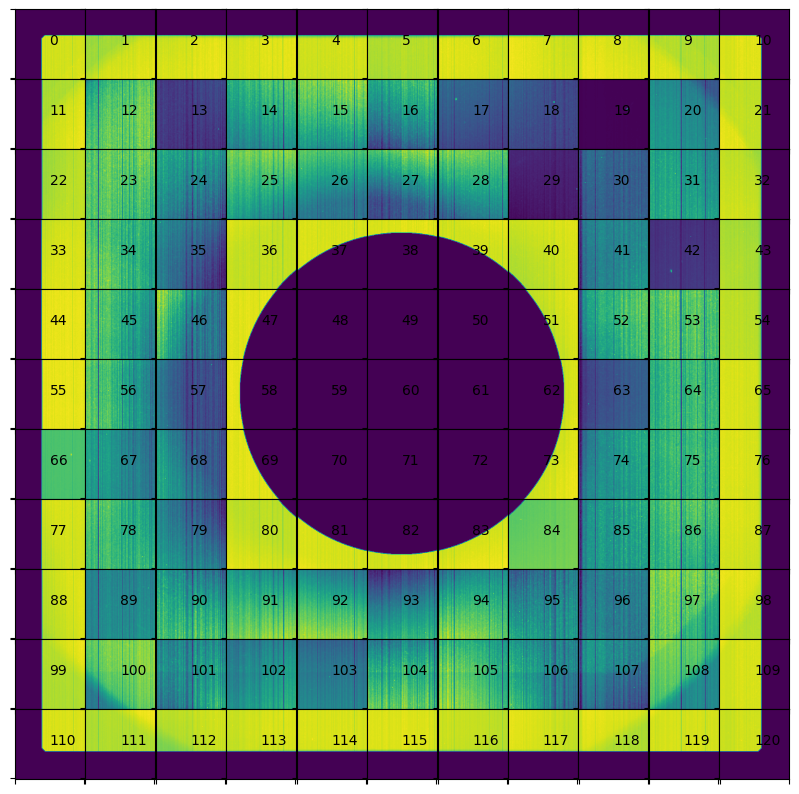

In [15]:
# Check proposal regions
# Create regions with size 200 and with a overlapping of 2.
regions, coordinates = image_slicer(raw_data , 200, 3)

# Plot and combine
fig, axis = plt.subplots(11, 11, figsize = (10,10))
axis = axis.flatten()
for idx, reg in enumerate(regions):
    axis[idx].imshow(regions[idx])
    axis[idx].set_xticklabels([])
    axis[idx].set_yticklabels([])
    axis[idx].text(100,100, str(idx))

plt.subplots_adjust(wspace=0, hspace=0)

Let's analyze the region where a point of interest was found.

[179, 1179]


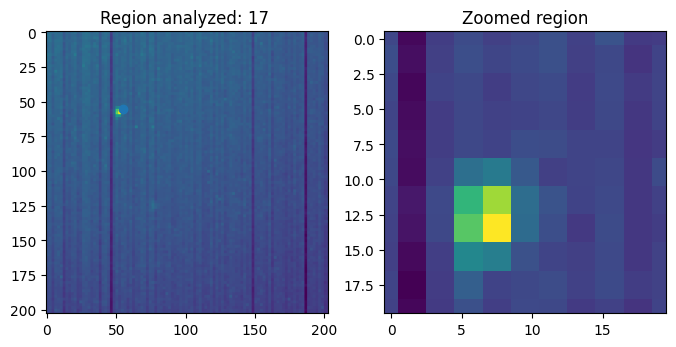

In [16]:
# Check region 17.
region_n = 17
# Crop region 17.
zoomed_image =regions[region_n][45:65, 45:65]

fig, axis = plt.subplots(1,2, figsize = (8,4))
axis[0].imshow(regions[region_n])
axis[0].set_title(f"Region analyzed: {region_n} ")
axis[1].imshow(zoomed_image)
axis[1].set_title("Zoomed region")
axis[0].scatter(55, 55)
found_pointed = coordinates[region_n][55][55]
print(found_pointed)

### 2.2.3 Peak detection.

First define a function that computes local statitics.

In [17]:
def statistics_region(region, sigma = 3.0):
    """
    Create a mask for 0 values in a region and compute statistics.

    Parameters:
    
        region (2d array): region to be masked and analyzed.
        sigma (float): sigma value for statistics.
    
    Return:
        mask (2d array): mask for peak detection.
        std (float): standard deviation of region.
        median (float): median of the data.
    """
    
    # Create mask for 0-valued items in the region.
    mask = region == 0
    # Compute statistics.
    mean, median, std = sigma_clipped_stats(region[~mask], sigma=3.0)

    return mask, std, median

Create function to determine whether a detected object is a star or not using a previously star catalogue obtained.

In [18]:
def star_comparison(dataframe, star_catalogue):
    """
    Check if a found object is a previously detected star by computing the euclidean distance between
    both points.
    
    Parameters:
        dataframe (table): astropy table with detected peaks.
        star_catalogue (table): astropy table with detected stars.
    
    """
    # Extract coordinates from the detected object.
    values = len(dataframe)
    for idx in range(values):

        x1 = dataframe["x_cord"].iloc[idx]
        y1 = dataframe["y_cord"].iloc[idx]

        # Run for all detected stars in star_catalogue.
        for stars in star_catalogue:
            # Extract star position.
            x2, y2 = stars["xsensor"], stars["ysensor"]
            # Compute euclidean distance.
            dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            if dist < 10:
                dataframe["star"].iloc[idx] = str(stars["MAIN_ID"])
            
    return dataframe


Create function to detect peaks in a 2D array.

In [19]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

def peak_detector(image, coordinates, coeff):
    """
    Detect points-of-interest in a 2d-array.

    Parameters:
        image (2d-array): image where points-of-interest may be found.
        coordinates (2d-array): real coordinates of the proposal region.
        coeff (int): coefficient for threshold in find_peaks.
    
    Return:
        points_of_interest (dataframe): dataframe with the detected points.
    """

    # Extract size
    size= image[0].shape[0]
    # Create dataframe for storing data.
    detected_peaks = pd.DataFrame(columns = ("region", "x_peak", "y_peak", "peak_value", "x_cord", "y_cord", "star", "std"))
    # Open all proposed regions and read one by one.
    for n_reg, reg in enumerate(image):
    
        # Create mask and compute statistics
        masked, std, median = statistics_region(reg)
        # Start peak detection.
        points = find_peaks(reg-median, threshold=coeff*std, box_size=size/2, 
                           npeaks=1, mask=masked)
    
        # Check for obtained values
        if points:
            # Iterate all over the rows in the detected points dataframe                
                real_pos = coordinates[n_reg][int(points["y_peak"]), int(points["x_peak"])]

                if len(get_iterable(real_pos)) == 2:
                    detected_peaks.loc[len(detected_peaks)] = [n_reg, points["x_peak"][0], points["y_peak"][0],
                                                            points["peak_value"][0]+median, real_pos[1], real_pos[0], "object", coeff]
                
    return detected_peaks         

Create function that removes the similar objects and keep the one with the highest peak value.

In [20]:
def remove_similar_objects(pandas_df, threshold = 5):
    """
    Given a pandas dataframe with detected objects, remove the duplicated ones.

    Parameters:
        pandas_df (dataframe): dataframe with object position and peak value.
        threshold (int): pixel distance between two objects for being considered same object.
    Return:
        cleaned_df (dataframe): cleaned dataframe with no duplicates.
    """

    # Create an array from 0 to size of dataframe.
    elements = np.arange(len(pandas_df))
    pairs = []

    # Create non repetitive pairs of indexes.
    for x, y in itertools.combinations(elements, 2):
        pairs.append([x,y])

    # Create list for duplicated elements
    remove_indexes = []

    # Iterate all over the pairs generated
    for pair in pairs:
        px, py = pair[0], pair[1]
        # Compute euclidean distance of detected objects
        y = (pandas_df["y_cord"].iloc[px] - pandas_df["y_cord"].iloc[py])**2
        x = (pandas_df["x_cord"].iloc[px] - pandas_df["x_cord"].iloc[py])**2
        dist = np.sqrt(y+x)
        # Store the index object whose peak was lower.
        if dist < threshold:
            index = [px if pandas_df["peak_value"].iloc[px] < pandas_df["peak_value"].iloc[py] else py]
            # Store index.
            remove_indexes.append(pandas_df.iloc[index[0]].name)

    # Remove repeated objec with lowest peak value.
    pandas_df = pandas_df.drop(remove_indexes)

    return pandas_df    


## 2.3 Tests

### 2.3.1 Test with Region 17

Try the peak detector with an known region.

In [21]:
# Compute statistics
masked, std, median = statistics_region(regions[17])
# Start peak detection.
points = find_peaks(regions[17] - median, threshold=3*std, box_size=20, 
                           npeaks=1, mask=masked)
# Show obtained points
print(points)

 id x_peak y_peak peak_value
--- ------ ------ ----------
  1     53     59      608.0


Display results.

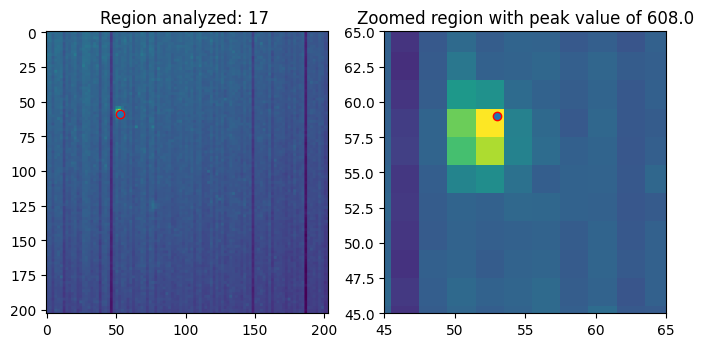

In [22]:
# Check region 17.
region_n = 17
fig, axis = plt.subplots(1,2, figsize = (8,4))
# Plot region 17.
axis[0].imshow(regions[region_n])
axis[0].set_title(f"Region analyzed: {region_n} ")
# Plot founded points-of-interested
axis[0].scatter(points["x_peak"], points["y_peak"], facecolors = None, edgecolors = "red")

# Zoom region
axis[1].imshow(regions[region_n])
axis[1].set_title(f"Zoomed region with peak value of {points['peak_value'][0]}")
axis[1].set_xlim(45,65), axis[1].set_ylim(45,65)
axis[1].scatter(points["x_peak"], points["y_peak"], facecolors = None, edgecolors = "red")

### 2.3.2 Threshold tunning with region 17.

In [23]:
# Create regions with size 50 and with a overlapping of 0.
regions_a, coordinates_a = image_slicer(regions[region_n], 50, 0)

Display created region.

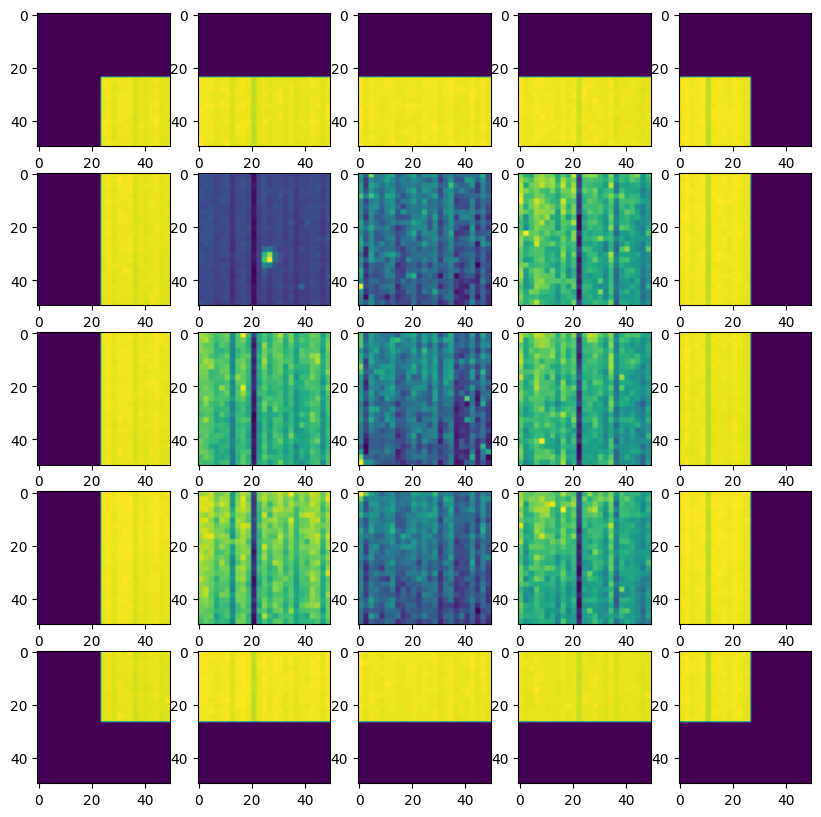

In [24]:
fig, axis = plt.subplots(5, 5, figsize = (10,10))
axis = axis.flatten()
for idx, reg in enumerate(regions_a):
    axis[idx].imshow(reg)

Now, run the peak detector function with different values for the threshold.

In [26]:
%matplotlib widget

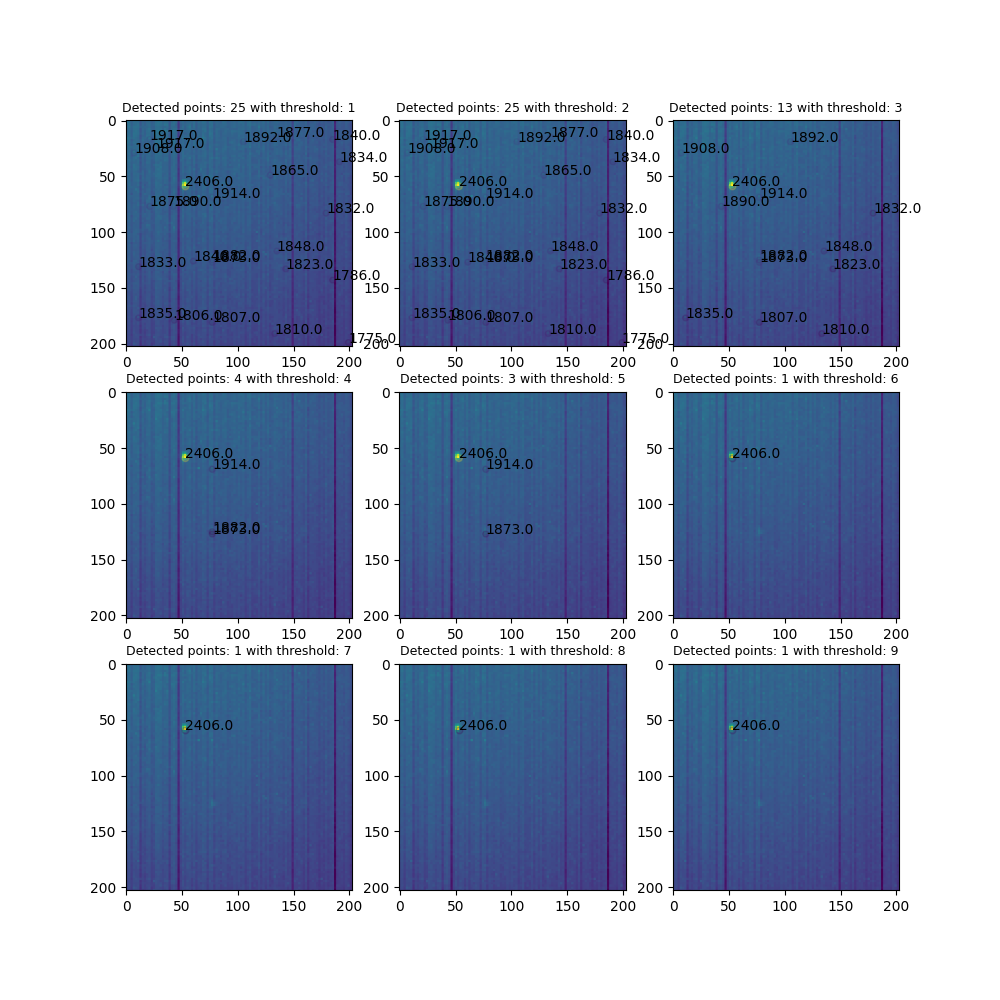

In [27]:
# Fine tune algorithm to reduce points
threshold_vals = [1, 2, 3, 4, 5, 6, 7, 8, 9]
fig, axis = plt.subplots(3, 3, figsize = (10,10))
axis = axis.flatten()

for idx in range(9):
    peaks_region_a= peak_detector(regions_a, coordinates_a, threshold_vals[idx])
    axis[idx].imshow(regions[region_n])
    a = axis[idx].scatter(peaks_region_a["x_cord"], peaks_region_a["y_cord"], s = peaks_region_a["peak_value"]/100,
                      c = peaks_region_a["peak_value"]/100, cmap = "viridis", alpha = 0.2)
    axis[idx].set_title(f"Detected points: {len(peaks_region_a)} with threshold: {threshold_vals[idx]}", fontsize = 9)
    for i in range(len(peaks_region_a)):
        axis[idx].text(peaks_region_a["x_cord"].iloc[i], peaks_region_a["y_cord"].iloc[i], str(peaks_region_a["peak_value"].iloc[i]))


For higher threshold values, the numbers of detected objects got reduced. 

### 2.3.3 Test with full L0 Image

In [28]:
# Initial parameters.
test_image = raw_data
size_region = 20
size_overlapping = 4
threshold_val = 7

# Create proposal regions.
regions_full, coordinates_full = image_slicer(test_image , size_region, size_overlapping)

# Run point-of-interest detector.
points_df = peak_detector(regions_full, coordinates_full, threshold_val)

# Remove duplicate values (due to overlapping cases).
points_df = points_df.drop_duplicates(subset=['x_cord', 'y_cord'])

# Check if stars are found.
points_df = star_comparison(points_df, table[0])

# Remove similar objects.
points_df_sorted = remove_similar_objects(points_df, 5)

# Sort peaks with higher values.
points_df_sorted = points_df_sorted.sort_values(by="peak_value", ascending=False)

print(f"Number of detected points: {len(points_df_sorted)} with a threshold value of {threshold_val}")

Number of detected points: 79 with a threshold value of 7


Plot points with higher peak values within the proposal regions.

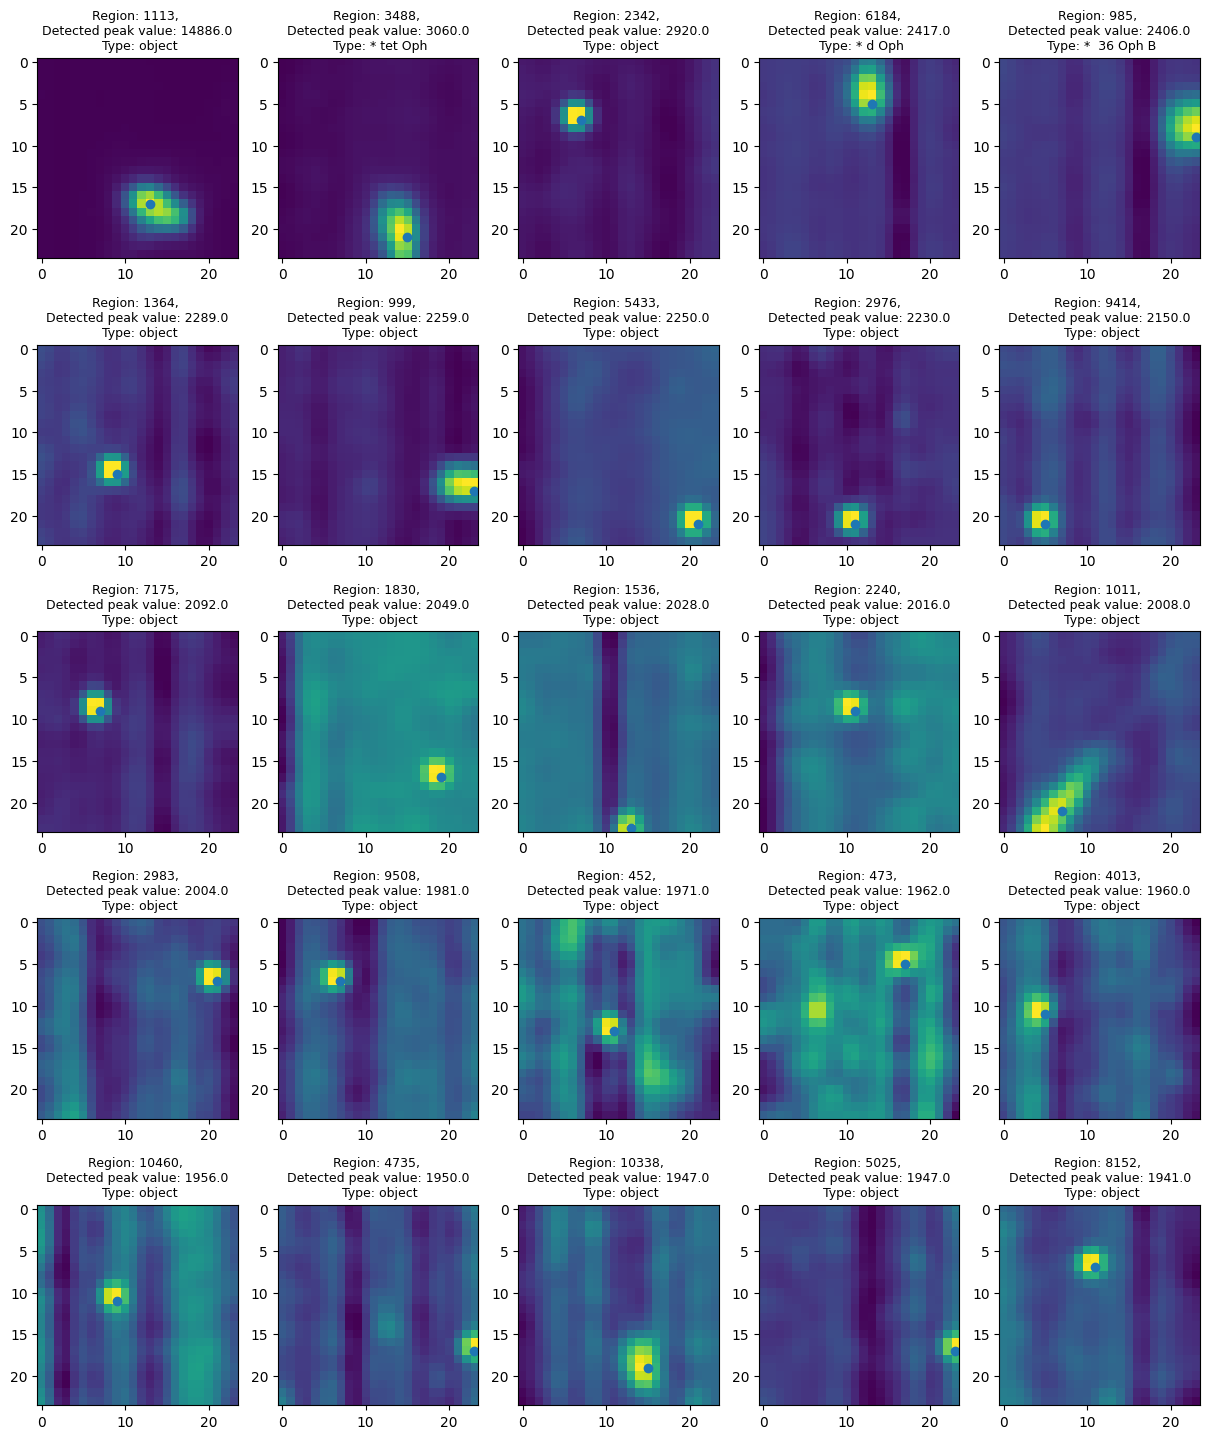

In [29]:
fig, axis = plt.subplots(5, 5, figsize = (15, 18))
axis = axis.flatten()
for idx in range(5*5): 
    # Extract region.
    region_idx = regions_full[int(points_df_sorted["region"].iloc[idx])]
    # Reduce noise.
    region_idx = gaussian_filter(region_idx, sigma=1)
    # Set floor to 0.
    background = np.min(region_idx)
    region_idx = region_idx - background
    region_idx[region_idx < 0] = 0                 
    axis[idx].imshow(region_idx)
    axis[idx].scatter(points_df_sorted["x_peak"].iloc[idx], points_df_sorted["y_peak"].iloc[idx])
    axis[idx].set_title(f"Region: {points_df_sorted['region'].iloc[idx]}, \n Detected peak value: {round(points_df_sorted['peak_value'].iloc[idx],3)} \n Type: {points_df_sorted['star'].iloc[idx]}", fontsize = 9)

Plot the obtained peaks

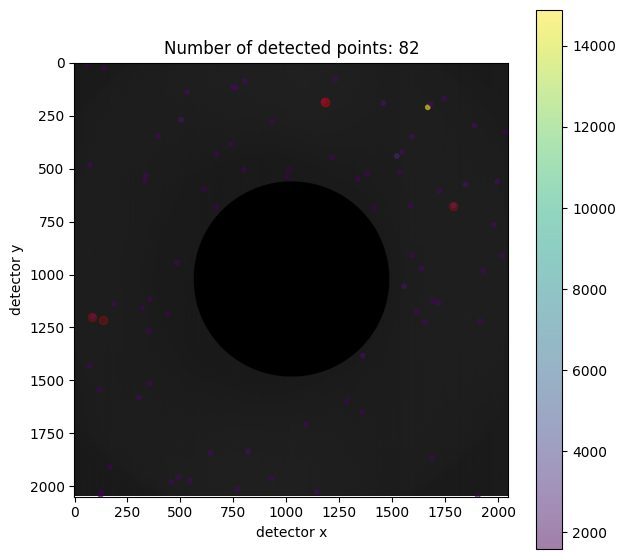

In [30]:
# Define the maximum number of points to be shown.
max_values = 1000
fig, axis = plt.subplots(1, 1, figsize = (7,7))
axis.imshow(raw_data, cmap = "grey")
scatter = axis.scatter(points_df_sorted["x_cord"].iloc[:max_values], points_df_sorted["y_cord"].iloc[:max_values],
                        c = points_df_sorted["peak_value"].iloc[:max_values], s=10, cmap = "viridis", alpha = 0.5)
# Display the detected stars given by the last run.
axis.scatter(table[0]["xsensor"], table[0]["ysensor"], c = "r", alpha = 0.2)
axis.set_title(f"Number of detected points: {len(points_df)}")
axis.set_xlabel("detector x")
axis.set_ylabel("detector y")
plt.colorbar(scatter)


Plot the obtained points with the higher peaks value using the full image.

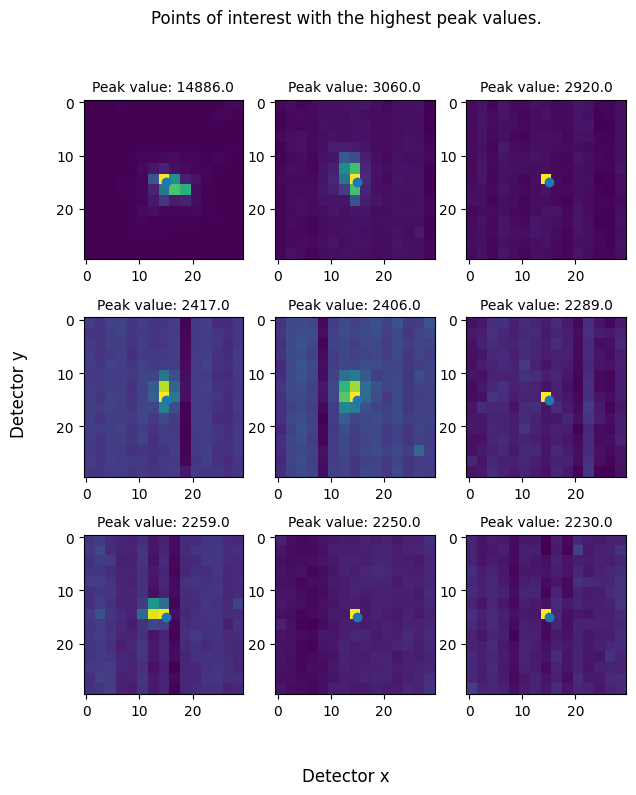

In [31]:
n_points = 3
lim = 15
fig, axis = plt.subplots(n_points, n_points, figsize = (7,8))
axis = axis.flatten()
plt.suptitle("Points of interest with the highest peak values.")
fig.supxlabel("Detector x")
fig.supylabel("Detector y")

points_detected = []

for i in range(n_points**2):
    x_o = points_df_sorted["y_cord"].iloc[i]
    y_o = points_df_sorted["x_cord"].iloc[i]
    
    points_detected.append([x_o, y_o])

    axis[i].imshow(raw_data[int(x_o-lim):int(x_o+lim), int(y_o-lim):int(y_o+lim) ])
    axis[i].set_title(f"Peak value: {round(points_df_sorted['peak_value'].iloc[i],3)}", size = 10)
    axis[i].scatter(lim, lim)

### 2.3.4 Check bright pixels.

In order to distinguish bright pixels from objects or stars, let's define a function that computes outliers in a given region. If the detected point is an outlier with respect of the proposal region, then it will be catalogued as a bright pixel.

In [ ]:
iqr

In [32]:
from scipy.stats import iqr
def iqr_test(array, x, y):
    """
    Detect outliers in a numpy 2d array.

    Parameters:
        array (array): 2d array from a cropped region.
        pixel (array): xy coordinate with pixel position.
    
    """
    # Flatten 2D image.
    pixel = array[x, y]
    flatten_array = array.flatten()
    iqr_val = iqr(flatten_array)

    # Compute Q1, Q3.
    Q1 = np.percentile(flatten_array, 25)
    Q3 = np.percentile(flatten_array, 75)
    lower_bound = Q1 - 1.5 * iqr_val
    upper_bound = Q3 + 1.5 * iqr_val

    if (pixel < lower_bound) | (pixel > upper_bound):
        return "bright pixel"
    else:
        return None


Test with region 2342.

Text(0, 0.5, 'detector y')

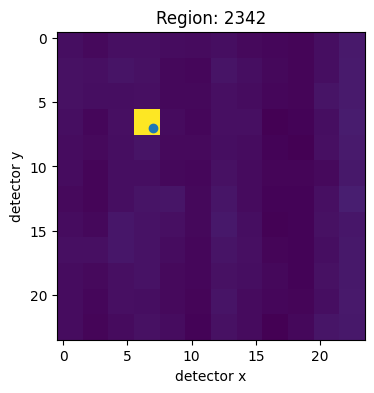

In [33]:
fig, axis = plt.subplots(1, 1, figsize = (4,4))
x = int(points_df_sorted[points_df_sorted["region"] == 2342]["x_peak"])
y = int(points_df_sorted[points_df_sorted["region"] == 2342]["y_peak"])
axis.imshow(regions_full[2342])
axis.scatter(x, y)
axis.set_title(f"Region: {2342}")
axis.set_xlabel("detector x")
axis.set_ylabel("detector y")

Run outlier detector.

In [34]:
# Run detector 
iqr_test(regions_full[2342], x, y )

'bright pixel'

Write a function that checks all the obtained objects and apply the iqr test for outlier detection.

In [35]:
def detect_outliers(dataframe, regions):
    """
    Given a pandas dataframe, check each proposal region and distinguish which ones are broken pixels.

    Parameters:
        dataframe (dataframe): pandas dataframe with detected objects.
    
    Return:
        classified_dataframe:
    """

    # Extract size.
    size_df = len(dataframe)
    
    for idx in range(size_df):
        # Extract region number.
        region_number = dataframe["region"].iloc[idx]
        # Compute coordinate with respect of the proposed region.
        x = int(dataframe[dataframe["region"] == region_number]["x_peak"])
        y = int(dataframe[dataframe["region"] == region_number]["y_peak"])
        # Check if detected point is an outlier
        val = iqr_test(regions[region_number], x, y)
        if val:
            dataframe["star"].iloc[idx] = val
    
    return dataframe
    
df_refined = detect_outliers(points_df_sorted, regions_full)    

### 2.3.5. Objects with different thresholds.

Run peak detector with different values for the threshold, merge them, delete the repeated ones.

In [36]:
def peaks_with_thresholds (image, size, overlapping, threshold_vals, stars):
    """
    Run peak detector function with different threshold values. Remove duplicates, merge them and filter again.

    Parameters:
        image (array): 2d array that contains image.
        size (int): size of the proposal regions.
        overlapping (int): size for the overlapping.
    
    Return:
        dataframe_obtained (list): list with dataframes from each run.
        objects_detected (list): number of detected objects in each run.
    """
    # Create regions and coordinates.
    regions, coordinates = image_slicer(image ,size, overlapping)
    # Store objects
    objects_detected = []
    dataframes_obtained = []
    stars_name = list(stars["MAIN_ID"])
    # Run for different threshold values.
    for tsh in threshold_vals:
        # Detect peaks.
        points_df = peak_detector(regions, coordinates, tsh)
        # Drop repeated points.
        points_df = points_df.drop_duplicates(subset=['x_cord', 'y_cord'])
        # Check if points are stars.
        points_df = star_comparison(points_df, stars)
        # Remove similar objects.
        points_df = remove_similar_objects(points_df, 5)
        # Detect bright pixels.
        points_df = detect_outliers(points_df, regions)
        # Store values in lists.
        objects_detected.append(len(points_df))
        dataframes_obtained.append(points_df)

    return  dataframes_obtained, objects_detected

std_vals = [3, 4, 5, 6, 7, 8, 9]
df_obt, obj_obt = peaks_with_thresholds(test_image, size_region, size_overlapping, std_vals, table[0])

Merge all the dataframes.

In [37]:
def merge_std_dataframes(list_dataframes):
    """
    Merge a set of pandas dataframes with different values for coefficients.
    Compare each element among themselves and keep the one with the highest threshold value.

    Parameters:
        list_dataframe (list): list with various pandas dataframes.
    Return:
        pandas_df (df): pandas dataframe with all values combined and filtered.
    """
    threshold = 3
    # Concat dfs and reset index.
    pandas_df = pd.concat(list_dataframes).reset_index()

    # Create array of size equals to the number of rows in new df.
    size = np.arange(len(pandas_df))
    pairs =[]
                     
    # Create non repetitive pairs of indexes.
    for x, y in itertools.combinations(size, 2):
        pairs.append([x,y])
    
    # Create list for duplicated elements
    remove_indexes = []
    # Iterate all over the pairs generated
    for pair in pairs:
        px, py = pair[0], pair[1]
        # Compute euclidean distance of detected objects
        y = (pandas_df["y_cord"].iloc[px] - pandas_df["y_cord"].iloc[py])**2
        x = (pandas_df["x_cord"].iloc[px] - pandas_df["x_cord"].iloc[py])**2
        dist = np.sqrt(y+x)
        # Store the index object whose peak was lower.
        if dist < threshold:
            index = [px if pandas_df["std"].iloc[px] <= pandas_df["std"].iloc[py] else py]
            # Store index.
            remove_indexes.append(px)

    # Remove repeated objec with lowest peak value.
    pandas_df = pandas_df.drop(remove_indexes)

    return pandas_df

In [38]:
# Merge previously obtained dataframes.
merged_df = merge_std_dataframes(df_obt)
# Sort by peak value
merged_df = merged_df.sort_values("peak_value", ascending= False)

Plot the obtained classes.

In [40]:
stars_name = list(table[0]["MAIN_ID"])
for i in range(len(df_obt)):
    df_obt[i]["star"] =  df_obt[i]["star"].replace(stars_name, "stars")  

([<matplotlib.axis.XTick at 0x7028535a95a0>,
 [Text(0.1, 0, 'broken pixels'),
  Text(1.1, 0, 'objects'),
  Text(2.1, 0, 'stars')])

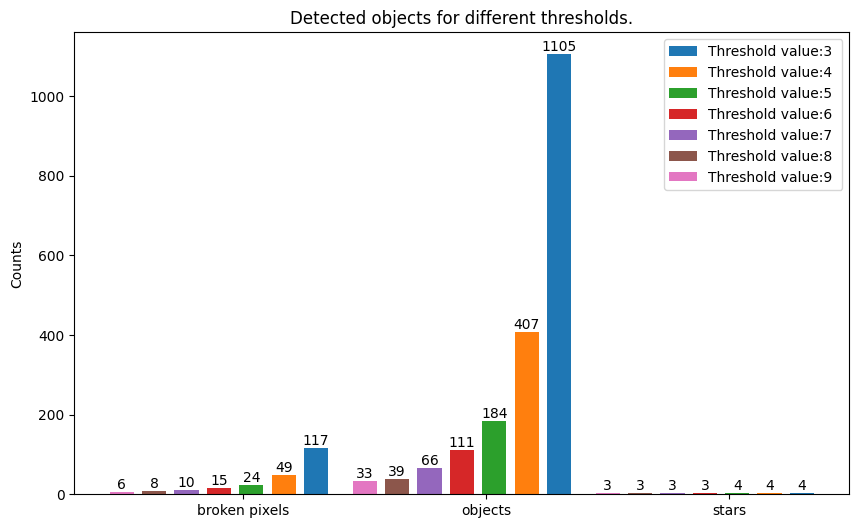

In [41]:
fig, axis = plt.subplots(1, 1, figsize = (10,6))
axis.set_ylabel("Counts")
axis.set_title("Detected objects for different thresholds.")
groups = len(df_obt[0].groupby("star").size().reset_index(name="count"))
x = np.arange(groups)
width = 0.1
widths = np.linspace(-4*width, + 4*width, 7)


for i in range(len(df_obt)):

    # For plotting, convert star labels into the same class.
    counts = df_obt[i].groupby("star").size().reset_index(name="count")["count"]
    bars = axis.bar(x - widths[i], df_obt[i].groupby("star").size().reset_index(name="count")["count"], width, label = f"Threshold value:{std_vals[i]} ")
    for bar in bars:
        height = bar.get_height()
        axis.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha="center", va="bottom")
    axis.legend()

plt.xticks([r + width for r in range(groups)], 
        ["broken pixels", "objects", "stars"])

### 2.3.6 Fit 2d-gaussian curve.

In order to distinguish the obtained objects, let's fit a 2d-gaussian model and retrieve the FWHM.

**First method implemented**

In [42]:
from scipy import optimize

def gaussian(height, center_x, center_y, width_x, width_y):
    """
    Returns a gaussian function with the given parameters
    """
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)


def moments(image):
    """
    Computes 2d gaussian parameters from a given 2d array.
    
    Parameters:
        image (2d-array): image to be analyzed.
    Output:
        height (float): amplitude of the image.
        x (float): mean in x.
        y (float): mean in y.
        width_x (float): std in x.
        width_y (float): std in y.

    """
    # Compute total light intensity.
    suma = image.sum()
    # Extract row and column indexes.
    Xi, Yi = np.indices(image.shape)
    # Compute weighted average of the x, y using intensities as weights.
    # Centroid computation.
    x = (Xi*image).sum() / suma
    y = (Yi*image).sum() / suma
    # Extract 1D slices of th image for estimating the widths.
    col = image[:, int(y)]
    row = image[int(x), :]
    # Compute standard deviation.
    width_x = np.sqrt(np.abs((np.arange(col.size)-x)**2*col).sum()/col.sum())
    width_y = np.sqrt(np.abs((np.arange(row.size)-y)**2*row).sum()/row.sum())
    # Find peak in the image.
    height = image.max()

    return height, x, y, width_x, width_y

def fitgaussian(data):

    """
    Fit the image using a 2d gaussian profile.

    Parameters:
        data (2d-array): image with 2d gaussian shape.
    Output:
        parameters (list): set of obtained gaussian paremeters (height, x_0, y_0, std_x, std_y)
    """

    # Compute intials parameters
    params = moments(data)
    # Define error function that minimizes the difference from the real data with the generated data.
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) - data)
    # Optimize 2d gaussian paremeters.
    parameters, success = optimize.leastsq(errorfunction, params)
    return parameters

Now, test the gaussian fittting with a previously obtained object.

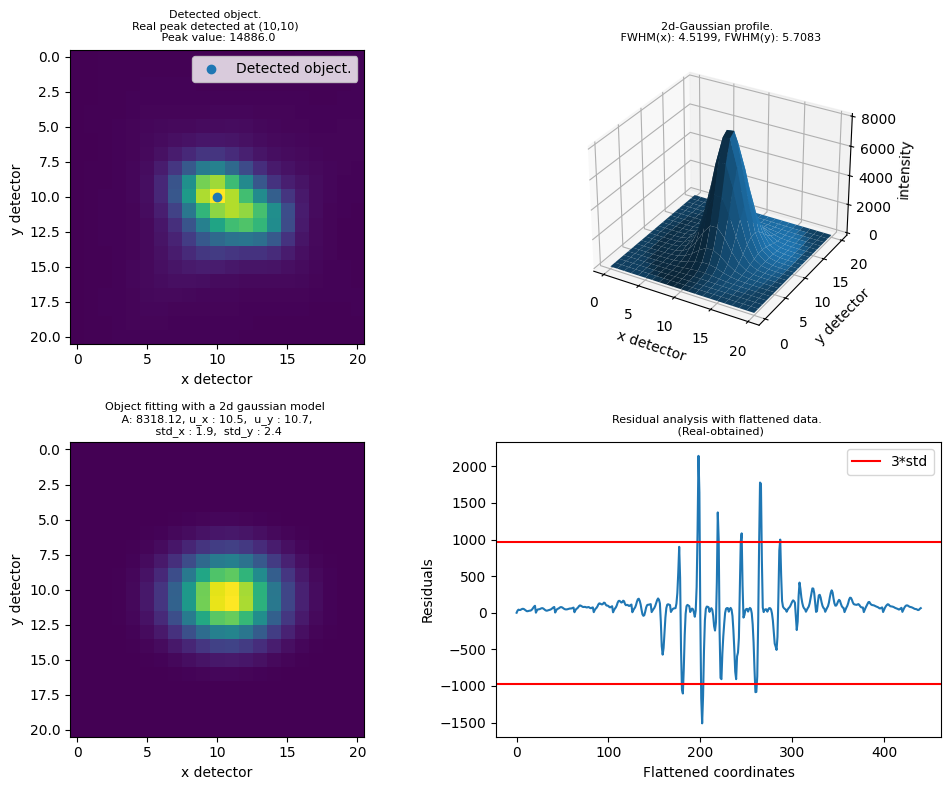

In [67]:
fig = plt.figure(figsize = (10,8))
# Select first object detected with highest peak.
index = 0

# Extract object coordinates.
x, y = int(points_df_sorted["x_cord"].iloc[index]), int(points_df_sorted["y_cord"].iloc[index])


# Crop full image with respect of obtained image.
lim = 10
region = raw_data[y-lim:y+lim+1, x-lim:x+lim+1]
# Reduce noise.
region = gaussian_filter(region, sigma=1)
# Set floor to 0.
background = np.min(region)
region = region - background
region[region < 0] = 0

# Run gaussian fitting.
parameters_obt  = fitgaussian(region)
amp, ux, uy, stdx, stdy = parameters_obt
fit = gaussian(*parameters_obt)
vals = fit(*np.indices(region.shape))


# Plot images
axis1 = fig.add_subplot(2, 2, 1)
axis1.imshow(region)
axis1.scatter(lim, lim, label ="Detected object.")
#axis1.contour(fit(*np.indices(region.shape)))
axis1.legend()
axis1.set_xlabel("x detector")
axis1.set_ylabel("y detector ")
peak_val_reg = points_df_sorted["peak_value"].iloc[index]
axis1.set_title(f"Detected object. \nReal peak detected at (10,10) \n Peak value: {peak_val_reg}", fontsize = 8)


# Plot 3d projection of obtained gaussian.
axis2 = fig.add_subplot(2, 2, 2, projection = "3d")

# Create grid.
X,Y = np.mgrid[0:21, 0:21]
#X,Y = np.meshgrid(np.arange(21), np.arange(21))
gauss = gaussian(*parameters_obt)
vals = gauss(X,Y)
axis2.plot_surface(X,Y,vals)
axis2.set_xlabel("x detector")
axis2.set_ylabel("y detector")
axis2.set_zlabel("intensity")
fwhmx = round(2.35482*stdx, 4)
fwhmy = round(2.35482*stdy, 4 )
axis2.set_title(f"2d-Gaussian profile. \n FWHM(x): {fwhmx}, FWHM(y): {fwhmy}", fontsize = 8)

# Plot 2d projection of obtained gaussian.
axis3 = fig.add_subplot(2, 2, 3)
axis3.imshow(vals)
axis3.set_xlabel("x detector")
axis3.set_ylabel("y detector")
axis3.set_title(f"Object fitting with a 2d gaussian model \n A: {round(amp, 2)}, u_x : {round(ux, 1)},  u_y : {round(uy, 1)}, \n std_x : {round(stdx, 1)},  std_y : {round(stdy, 1)}", fontsize =8)
#axis3.contour(fit(*np.indices(region.shape)))

# Check residuals.
axis4 = fig.add_subplot(2, 2, 4)
residuals = region.flatten() - vals.flatten()
std_residuals = np.std(residuals)
axis4.plot(residuals)
axis4.set_xlabel("Flattened coordinates")
axis4.set_ylabel("Residuals")
axis4.set_title("Residual analysis with flattened data. \n (Real-obtained)", fontsize =8)
axis4.axhline(3*std_residuals, color ="red", label ="3*std") 
axis4.axhline(-3*std_residuals, color ="red") 
axis4.legend()


plt.tight_layout()

Try other example.

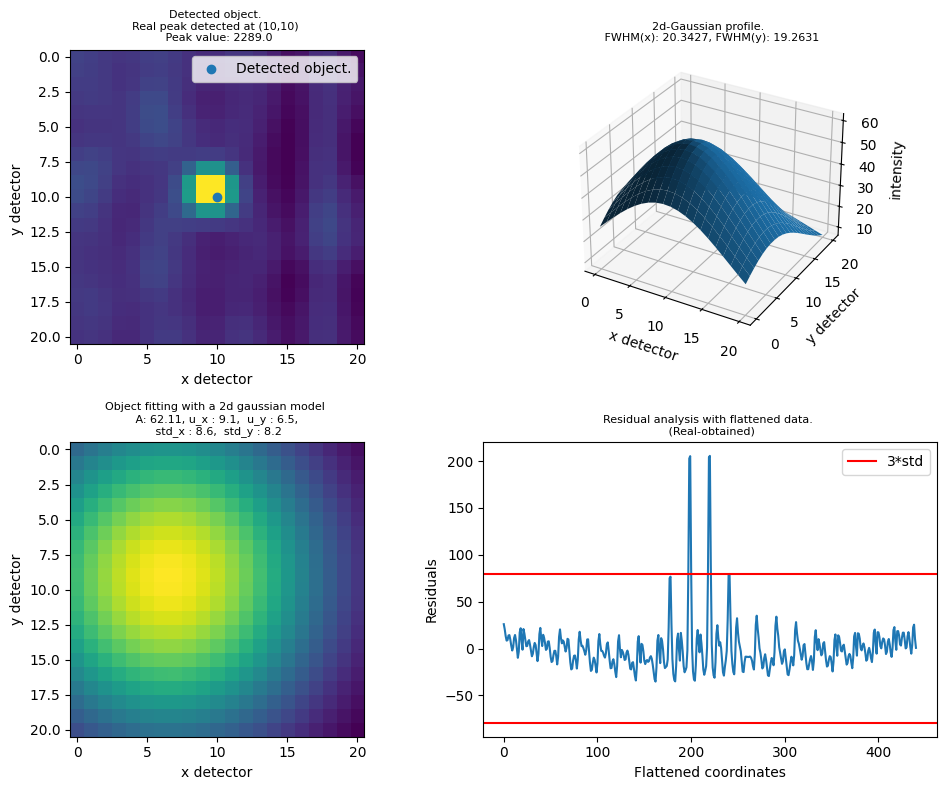

In [68]:
fig = plt.figure(figsize = (10,8))
# Select first object detected with highest peak.
index = 5

# Extract object coordinates.
x, y = int(points_df_sorted["x_cord"].iloc[index]), int(points_df_sorted["y_cord"].iloc[index])


# Crop full image with respect of obtained image.
lim = 10
region = raw_data[y-lim:y+lim+1, x-lim:x+lim+1]
# Reduce noise.
region = gaussian_filter(region, sigma=1)
# Set floor to 0.
background = np.min(region)
region = region - background
region[region < 0] = 0

# Run gaussian fitting.
parameters_obt  = fitgaussian(region)
amp, ux, uy, stdx, stdy = parameters_obt
fit = gaussian(*parameters_obt)
vals = fit(*np.indices(region.shape))


# Plot images
axis1 = fig.add_subplot(2, 2, 1)
axis1.imshow(region)
axis1.scatter(lim, lim, label ="Detected peak.")
axis1.legend()
axis1.set_xlabel("x detector")
axis1.set_ylabel("y detector ")
axis1.set_title(f"Detected object." fontsize = 8)


# Plot 3d projection of obtained gaussian.
axis2 = fig.add_subplot(2, 2, 2, projection = "3d")

# Create grid.
X,Y = np.mgrid[0:21, 0:21]
#X,Y = np.meshgrid(np.arange(21), np.arange(21))
gauss = gaussian(*parameters_obt)
vals = gauss(X,Y)
axis2.plot_surface(X,Y,vals)
axis2.set_xlabel("x detector")
axis2.set_ylabel("y detector")
axis2.set_zlabel("intensity")
fwhmx = round(2.35482*stdx, 4)
fwhmy = round(2.35482*stdy, 4 )
axis2.set_title(f"2d-Gaussian profile. \n FWHM(x): {fwhmx}, FWHM(y): {fwhmy}", fontsize = 8)

# Plot 2d projection of obtained gaussian.
axis3 = fig.add_subplot(2, 2, 3)
axis3.imshow(vals)
axis3.set_xlabel("x detector")
axis3.set_ylabel("y detector")
axis3.set_title(f"Object fitting with a 2d gaussian model \n A: {round(amp, 2)}, u_x : {round(ux, 1)},  u_y : {round(uy, 1)}, \n std_x : {round(stdx, 1)},  std_y : {round(stdy, 1)}", fontsize =8)
#axis3.contour(fit(*np.indices(region.shape)))

# Check residuals.
axis4 = fig.add_subplot(2, 2, 4)
residuals = region.flatten() - vals.flatten()
std_residuals = np.std(residuals)
axis4.plot(residuals)
axis4.set_xlabel("Flattened coordinates")
axis4.set_ylabel("Residuals")
axis4.set_title("Residual analysis with flattened data. \n (Real-obtained)", fontsize =8)
axis4.axhline(3*std_residuals, color ="red", label ="3*std") 
axis4.axhline(-3*std_residuals, color ="red") 
axis4.legend()


plt.tight_layout()

Unfortunately, it is not working properly for noiser samples. Try new model!

**Second method implemented**

In [78]:
# Define gaussian model with offset.
from scipy.optimize import curve_fit

def gaussian_2d(coords, A, x0, y0, sigma_x, sigma_y, C):
    """2D Gaussian with offset"""
    x, y = coords
    return A * np.exp(-(((x - x0)**2) / (2 * sigma_x**2) + ((y - y0)**2) / (2 * sigma_y**2))) + C

def gaussian_fitter(image, x, y):
    """
    Fit a 2D-Gaussian function in a image and return the obtained parameters.

    Params:
        image (2d-array): image with possible gaussian.

    Returns:
        A (float): amplitude.
        ux (float): mean in x.
        uy (float): mean in y.
        stdx (float): std in x.
        stdy (float): std in y.
    """

    # Convert 2D into 1D data.
    x_flatted = x.ravel()
    y_flatted = y.ravel()
    image_flatted = image.ravel()

    # Compute intial guess.
    A_0 = np.max(image)
    x0_0 = image.shape[1] // 2  
    y0_0 = image.shape[0] // 2  
    stdx_0 = image.shape[1] / 10  
    stdy_0 = image.shape[0] / 10
    C_0 = np.min(image) 

    # Start fitting
    popt, pcov = curve_fit(gaussian_2d, (x_flatted, y_flatted),
                            image_flatted, p0=(A_0, x0_0, y0_0, stdx_0, stdy_0, C_0))
    
    # Extract parameters
    A, ux, uy, stdx, stdy, C = popt
    
    return A, ux, uy, stdx, stdy, C


In [109]:
def plot_2dgaussian_comp(image, index, dataframe, lim):
    """
    Display 2d-gaussian fitting.
    """
    # Prepare image.
    fig = plt.figure(figsize = (12,12))

    ## Generate image ##
    # Extract x. y position
    xx, yy = int(dataframe["x_cord"].iloc[index]), int(dataframe["y_cord"].iloc[index])

    # Crop full image with respect of obtained image.
    region = image[yy-lim:yy+lim+1, xx-lim:xx+lim+1]
    # Reduce noise.
    region = gaussian_filter(region, sigma=1)
    # Set floor to 0.
    background = np.min(region)
    region = region - background
    region[region < 0] = 0

    # Run gaussian fitting
    x = np.arange(region.shape[1])
    y = np.arange(region.shape[0])
    x, y = np.meshgrid(x,y)

    parameters = gaussian_fitter(region, x, y)
    computed_gaussian = gaussian_2d((x, y), *parameters).reshape(region.shape)
    amp, ux, uy, stdx, stdy, C = parameters

    ## Create plots ##

    # 1. Plot region to be analyzed.
    axis1 = fig.add_subplot(2, 2, 1)
    axis1.imshow(region)
    axis1.scatter(lim, lim, label ="Detected peak.")
    axis1.legend()
    axis1.set_xlabel("x detector")
    axis1.set_ylabel("y detector ")
    axis1.set_title("Detected object.", fontsize = 8)


    # 2. Plot 3d projection of obtained gaussian.
    axis2 = fig.add_subplot(2, 2, 2, projection = "3d")
    axis2.plot_surface(x,y,computed_gaussian)
    axis2.set_xlabel("x detector")
    axis2.set_ylabel("y detector")
    axis2.set_zlabel("intensity")
    fwhmx = round(2.35482*stdx, 4)
    fwhmy = round(2.35482*stdy, 4 )
    axis2.set_title(f"2d-Gaussian profile. \n FWHM(x): {fwhmx}, FWHM(y): {fwhmy}", fontsize = 8)

    # 3. Plot 2d projection of obtained gaussian.
    axis3 = fig.add_subplot(2, 2, 3)
    axis3.imshow(computed_gaussian)
    axis3.set_xlabel("x detector")
    axis3.set_ylabel("y detector")
    axis3.set_title(f"Object fitted with a 2d gaussian model \n A: {round(amp, 2)}, u_x: {round(ux, 1)}, u_y: {round(uy, 1)}, std_x: {round(stdx, 1)}, std_y: {round(stdy, 1)}, offset: {round(C,1)}", fontsize =8)

    # 4. Check residuals.
    axis4 = fig.add_subplot(2, 2, 4)
    residuals = region.flatten() - computed_gaussian.flatten()
    std_residuals = np.std(residuals)
    axis4.plot(residuals)
    axis4.set_xlabel("Flattened coordinates")
    axis4.set_ylabel("Residuals")
    axis4.set_title("Residual analysis with flattened data. \n (Real-obtained)", fontsize =8)
    axis4.axhline(3*std_residuals, color ="red", label ="3*std") 
    axis4.axhline(-3*std_residuals, color ="red") 
    axis4.legend()


Try new model on region with problems.

In [110]:
points_df_sorted

,region,x_peak,y_peak,peak_value,x_cord,y_cord,star,std
14,1113,13,17,14886.0,1667,211,object,7
48,3488,15,21,3060.0,1789,675,* tet Oph,7
30,2342,7,7,2920.0,1521,441,bright pixel,7
76,6184,13,5,2417.0,87,1199,* d Oph,7
9,985,23,9,2406.0,1177,183,* 36 Oph B,7
...,...,...,...,...,...,...,...,...
45,3120,17,1,1629.0,611,595,object,7
33,2625,17,7,1624.0,1011,501,object,7
38,2831,9,3,1617.0,1003,537,object,7
109,10512,9,7,1602.0,123,2041,object,7


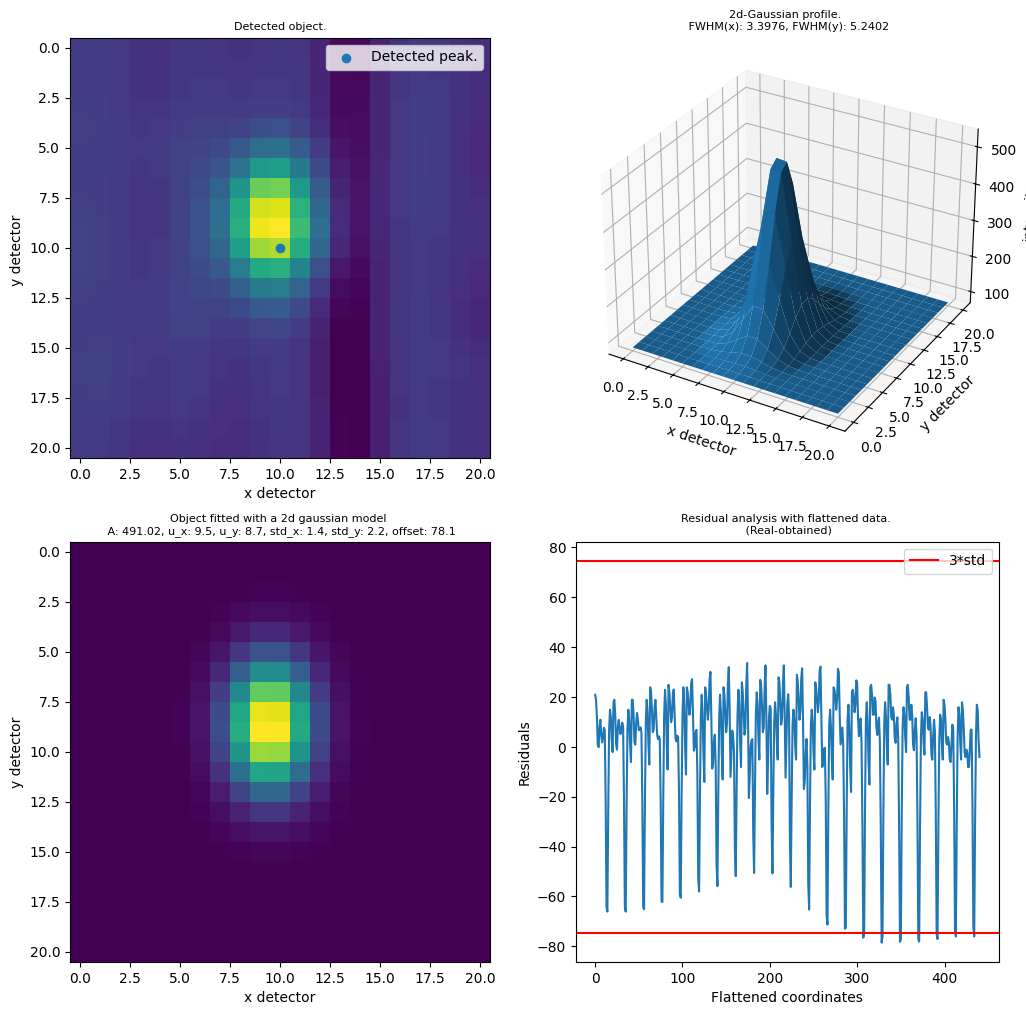

In [114]:
plot_2dgaussian_comp(raw_data, 3, points_df_sorted, 10)

### 2.3.7 Noise detection

Detect if an detected object is noise using Noise Power.

In [210]:
# Try with object 50
index = 50
# Extract object coordinates.
x, y = int(points_df_sorted["x_cord"].iloc[index]), int(points_df_sorted["y_cord"].iloc[index])

# Crop full image with respect of obtained image.
lim = 10
region = full_image_norm[y-lim:y+lim+1, x-lim:x+lim+1]

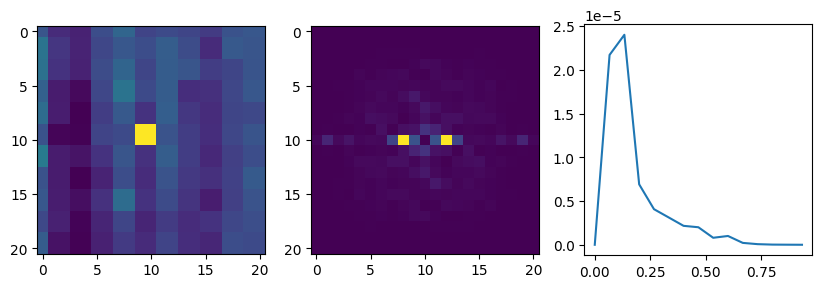

In [215]:
# Compute noise power spectrum usind ICRU.
nps2d = noise_power_spectrum_2d(pixel_size=1, rois = [region])
nps1d = noise_power_spectrum_1d(spectrum_2d=nps2d)

fig, axis = plt.subplots(1, 3, figsize = (10, 3))
axis[0].imshow(region)

axis[1].imshow(nps2d)

x_vals = np.arange(len(nps1d))/len(nps1d)
axis[2].plot(x_vals, nps1d)

## 2.4 Store points

Create a function that takes a dataframe full of detected objects and print them on a pdf.

In [99]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def plot_to_pdfs(image, dataframe, name_file):
    """
    Convert 2d arrays from a pandas dataframe into a pdf.

    Parameters:
        image (2d-array): image which was used to search objects.
        dataframe (dataframe): pandas dataframe with objects.
        name_dile (str): file name where data will be exported.
    
    """
    # Extract number of plots.
    number_plots = len(dataframe)

    # Define pdf structure.
    n_pages = math.ceil(number_plots/50)
    n_col = 5
    n_row = 10
    lim = 10
    # Set index page.
    j = 0

    # Start pdf. document.
    with PdfPages(name_file) as pdf:
        # Iterate in pages.
        for page in range(n_pages):
            # Create plot in pages.
            fig, axis = plt.subplots(n_row, n_col, figsize = (10, 20))
            plt.subplots_adjust(wspace=0.3, hspace=0.6)
            axis = axis.flatten()
            
            # Create subplots and display desired data
            for i in range(n_row*n_col):
                if (i+j)< number_plots:
                    x0 = int(dataframe["y_cord"].iloc[i+j])
                    y0 = int(dataframe["x_cord"].iloc[i+j])
                    peak = round(dataframe["peak_value"].iloc[i+j], 3)
                    type = dataframe["star"].iloc[i+j]
                    region_number = dataframe["region"].iloc[i+j]
                    std_val = dataframe["std"].iloc[i+j]
                    axis[i].imshow(image[ x0 - lim: x0 + lim + 1, y0 - lim : y0 + lim +1])
                    axis[i].set_title(f"Region number: {region_number} \n Detected at (x,y): {x0}, {y0} \n with peak value: {peak} \n Type: {type}, Std: {std_val}", fontsize = 6)
                    axis[i].set_xticklabels([])
                    axis[i].set_yticklabels([])
            

            
                else: 
                    fig.delaxes(axis[i])
            
            j = j + n_col*n_row
            
            # Adjust layout
            #plt.tight_layout()
            # Save the current figure to the PDF
            pdf.savefig(fig)
            plt.close(fig)  # Close the figure to free memory

Export data into pdfs.

In [157]:
# Export objects into pdf.
plot_to_pdfs(full_image_norm, points_df_sorted, "points_of_interest.pdf")

In [168]:
# Export dataframe with many thresholds examples.
plot_to_pdfs(full_image_norm, merged_df,"all_objects.pdf")

## Bibliography

Noise analysis using Fourier:

https://pylinac.readthedocs.io/en/release_update/topics/nps.html

2D gaussian fitting:

https://scipy-cookbook.readthedocs.io/items/FittingData.html